# 파일마다 경로 확인 먼저 해주세요 !

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
# module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
# 글자 크기
plt.rcParams['font.size'] = 13

import seaborn as sns

# 불필요한 경고 메시지를 나오지 않도록 한다.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
order = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/handal/주문_상품별_상세검색_210927155232.xlsx')
cus = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/handal/고객_상세검색_210927155247.xls')

order.rename(columns = {'주문자 이메일': '이메일'}, inplace = True)
order.rename(columns = {'주문자 휴대폰 번호': '휴대폰 번호'}, inplace = True)

# 고객데이터


## 변수 선택

In [ ]:
cus_df = cus[['소셜 로그인', '카카오 계정 연동', '이메일', '이름', '휴대폰 번호', '주소', '생년월일', '성별', '구매 횟수', '구매 금액', '가입일자', '최근 로그인', '최근 수정일', '메모', '마케팅 문자 수신 동의 여부', '마케팅 이메일 수신 동의 여부']]

# 관리자 제거
cus_df = cus_df[ : 1747]

# 구매 금액이 '-' 인 부분을 모두 0으로 바꿔줌
cus_df.loc[cus_df['구매 금액'] == '-', '구매 금액'] = 0

In [ ]:
cus_df['구매 금액'] = cus_df['구매 금액'].astype('int')

## 주소 대분류

In [ ]:
cus_df['주소 분할'] = cus_df['주소']
for i in range(len(cus_df)) :
  cus_df['주소 분할'].loc[i] = cus_df.loc[i]['주소'].split()[0]

## 나이, 연령대 추가

In [ ]:
# 나이, 연령대 추가
cus_df['생년'] = [i[:4] for i in cus_df['생년월일']]

# 생년월일이 잘못 기재된 데이터들 바꿔줌
cus_df['생년'].loc[cus_df['생년'] == '02-0'] = '2002'
cus_df['생년'].loc[cus_df['생년'] == '94-0'] = '1994'
cus_df['생년'].loc[cus_df['생년'] == '7912'] = '1979'

# 생년월일이 없는 데이터들은 일단 0으로 변경
cus_df['생년'].loc[cus_df['생년'] == '-'] = '0'

# 나이
cus_df['나이'] = [2021 - int(i) + 1 for i in cus_df['생년']]

# 연령대
cus_df['연령대'] = cus_df['나이']
for i in range(len(cus_df)) :
  if cus_df['나이'].loc[i] >= 200 :
    cus_df['연령대'].loc[i] = '-'
  elif cus_df['나이'].loc[i] >= 60 :
    cus_df['연령대'].loc[i] = '60대 이상'
  elif cus_df['나이'].loc[i] >= 55 :
    cus_df['연령대'].loc[i] = '50대 후반'
  elif cus_df['나이'].loc[i] >= 50 :
    cus_df['연령대'].loc[i] = '50대 초반'
  elif cus_df['나이'].loc[i] >= 45 :
    cus_df['연령대'].loc[i] = '40대 후반'
  elif cus_df['나이'].loc[i] >= 40 :
    cus_df['연령대'].loc[i] = '40대 초반'
  elif cus_df['나이'].loc[i] >= 35 :
    cus_df['연령대'].loc[i] = '30대 후반'
  elif cus_df['나이'].loc[i] >= 30 :
    cus_df['연령대'].loc[i] = '30대 초반'
  elif cus_df['나이'].loc[i] >= 25 :
    cus_df['연령대'].loc[i] = '20대 후반'
  elif cus_df['나이'].loc[i] >= 20 :
    cus_df['연령대'].loc[i] = '20대 초반'
  elif cus_df['나이'].loc[i] >= 10 :
    cus_df['연령대'].loc[i] = '10대'
  else :
    cus_df['연령대'].loc[i] = '10대 미만'

# 생년월일이 없는 데이터들은 일단 0으로 변경
cus_df['생년'].loc[cus_df['생년'] == '0'] = '-'
cus_df['나이'].loc[cus_df['나이'] == 2022] = '-'

## 상품 구매 내역 추가

In [ ]:
# 구매 내역이 있는 고객들
order_cus = cus_df[cus_df['구매 횟수'] != 0]

# 구매 내역이 있는 고객들의 메일
order_cus_mail = order_cus['이메일'].values

item_dict = {}
for i in order_cus_mail :
  item_dict[i] = order[order['이메일'] == i]['상품 이름'].values
  
cus_df['상품 목록'] = '-'
for i in item_dict :
  cus_df['상품 목록'].loc[cus_df['이메일'] == i] = [item_dict[i]]

## 첫 상품 구매 내역 추가

In [ ]:
# 이메일과 주문일자를 기준으로 order 데이터를 정렬하면 각 이메일별로 첫번째 관측치들이 첫 상품 구매 내역이 된다.
order_sort = order.sort_values(by = ['이메일', '주문 일자'])

# 고객들의 메일
order_sort_mail = order_sort['이메일'].value_counts().index

first_item_dict = {}
for i in order_sort_mail :
  first_item_dict[i] = order_sort[order_sort['이메일'] == i]['상품 이름'].iloc[0]

cus_df['첫 구매 상품'] = '-'
for i in first_item_dict :
  cus_df['첫 구매 상품'].loc[cus_df['이메일'] == i] = first_item_dict[i]

# 주문 데이터 

###### 세팅

In [ ]:
#설치 후 진행!
!pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=015e4ff4abc20ebaedff3ef0cd3f911710bde40c5ee35ce210447b845ad6e47e
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import pandasql as ps
from pandasql import sqldf
order2 = order
ps.sqldf("""select * from order2 limit 3""")

,상품 이름,주문자 이름,휴대폰 번호,이메일,상품별 결제 금액,상품별 주문 상태,배송지 이름,배송지 휴대폰 번호,우편번호,배송지 주소,배송 시 요청 사항,주문 상태,주문 품목 개수,부분 취소 금액,부분 취소 후 잔액,상품 합계 금액,배송비,배송 메모,주문 일자,결제 방법,수량,메모,주문 제목,결제 금액,취소/반품 상품 수량,주문번호,상품 주문번호 (네이버페이),주문자 유형,주문자 아이디,택배회사,송장번호,개인통관고유부호,사용한 적립금,적립될 적립금,사용한 쿠폰,쿠폰 할인 금액,사용한 할인 코드,할인 코드 할인 금액,총 할인 금액,상품 부분 취소 전 상품 합계 금액,상품 부분 취소 전 배송비,상품 부분 취소 전 사용한 적립금,상품 부분 취소 전 적립될 적립금,상품 부분 취소 전 쿠폰 할인 금액,상품 부분 취소 전 할인 코드 할인 금액,상품 부분 취소 전 총 할인 금액,입금받을 계좌 정보,입금자,입금 기한,에스크로,TID,환불 계좌,취소/반품 사유,상품 코드,상품 옵션 정보,추가 옵션 정보,작성형 옵션 정보,주문 수량과 관계없이 고정된 추가 옵션 추가 금액
0,한달 브런치 공모전 도전하기 10/4(월)~10/24(일),채송아,010-3472-4876,110933@naver.com,89100,승인,채송아,010-3472-4876,-,None,-,결제 완료,1,-,-,89100,0,-,2021-09-27 12:08:26,카카오페이,1,-,한달 브런치 공모전 도전하기 10/4(월)~10/24(일),89100,0,20210927XVKGB,-,회원,-,기타,-,None,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,T2946604017788574499,-,-,-,-,-,-,-
1,[ 3일 독서 ] 기분이 태도가 되지 않게 10/12(화)~10/14(목),최효진,010-8359-4469,chj3412@kakao.com,0,승인,최효진,010-8359-4469,-,None,-,결제 완료,1,-,-,0,0,-,2021-09-27 11:09:32,-,1,-,[ 3일 독서 ] 기분이 태도가 되지 않게 10/12(화)~10/14(목),0,0,20210927YDK6V,-,회원,-,기타,-,None,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,한달 독서,김상헌,010-2066-0827,act882@kakao.com,59400,승인,김상헌,010-2066-0827,-,None,-,결제 완료,1,-,-,59400,0,-,2021-09-27 10:51:35,카카오페이,1,-,한달 독서,59400,0,202109275TQB7,-,회원,-,기타,-,None,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,T2946584209402034161,-,-,30dr0001,-,-,-,-


In [ ]:
order2 = order
order2 = order[['주문자 이름', '휴대폰 번호', '이메일', '상품별 결제 금액','결제 방법','수량', '메모','결제 금액', '취소/반품 상품 수량', '주문 일자', '주문 상태','주문번호','상품 주문번호 (네이버페이)','주문자 유형', '주문자 아이디','취소/반품 사유', '상품 코드', '상품 이름']]
order2.rename(columns={"상품 이름": "상품이름", "상품별 결제금액": "상품별결제금액", "결제 금액":"결제금액", "취소/반품 상품 수량":"취소및반품수량", "주문 상태":"주문상태", "취소/반품 사유":"취소반품사유", "주문자 유형":"주문자유형", "주문자 아이디":"주문자아이디" }, inplace = True)

In [ ]:
order2 = order2[order2['주문상태'] != '취소 완료'].reset_index(drop = True)

###### 기간에 따른 상품 구분 

In [ ]:
# 컬럼 생성 : type  : 하루 = 0, 3일 = 1, 7일 = 2, 한달 = 3
order2['type'] = ""
order2['type'] = order['상품 이름'].apply(lambda x : '수입' if ('한달머니') in x else('하루' if ('1일바리스타' in x) | ('피크닉' in x) else ('굿즈' if '굿즈'in x else ('3일' if ('3일' in x) else ('7일' if '7일' in x else ('한달' if '한달' in x else ('하루' if '하루' in x else ('2주' if '8/31(화)~9/13(월)' in x else '기타') )))))))

order2

,주문자 이름,휴대폰 번호,이메일,상품별 결제 금액,결제 방법,수량,메모,결제금액,취소및반품수량,주문 일자,주문상태,주문번호,상품 주문번호 (네이버페이),주문자유형,주문자아이디,취소반품사유,상품 코드,상품이름,type
0,채송아,010-3472-4876,110933@naver.com,89100,카카오페이,1,-,89100,0,2021-09-27 12:08:26,결제 완료,20210927XVKGB,-,회원,-,-,-,한달 브런치 공모전 도전하기 10/4(월)~10/24(일),한달
1,최효진,010-8359-4469,chj3412@kakao.com,0,-,1,-,0,0,2021-09-27 11:09:32,결제 완료,20210927YDK6V,-,회원,-,-,-,[ 3일 독서 ] 기분이 태도가 되지 않게 10/12(화)~10/14(목),3일
2,김상헌,010-2066-0827,act882@kakao.com,59400,카카오페이,1,-,59400,0,2021-09-27 10:51:35,결제 완료,202109275TQB7,-,회원,-,-,30dr0001,한달 독서,한달
3,김상헌,010-2066-0827,act882@kakao.com,0,-,1,-,0,0,2021-09-27 10:50:19,결제 완료,20210927NALQA,-,회원,-,-,-,[ 3일 독서 ] 기분이 태도가 되지 않게 10/12(화)~10/14(목),3일
4,김상헌,010-2066-0827,act882@kakao.com,0,-,1,-,0,0,2021-09-27 10:49:33,결제 완료,20210927HFBSH,-,회원,-,-,-,"[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",3일
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,김숙희,010-6559-6995,shkdra@naver.com,50000,신용 / 체크카드,1,-,50000,0,2020-07-22 22:52:06,거래 완료,20200722FCXAP,-,회원,-,-,-,한달브런치,한달
2994,김미경,010-5175-1240,cherish1240@naver.com,50000,신용 / 체크카드,1,-,50000,0,2020-07-22 22:39:14,거래 완료,202007221HABM,-,회원,-,-,-,한달미디엄,한달
2995,배동민,010-5064-1833,albilleo@naver.com,30000,카카오페이,1,-,30000,0,2020-07-22 22:16:18,거래 완료,20200722ACLEL,-,회원,-,-,-,한달쓰기,한달
2996,오미영,010-9278-5824,om55824@naver.com,50000,카카오페이,1,-,50000,0,2020-07-22 21:47:37,거래 완료,20200722UWJSL,-,회원,-,-,-,한달서평,한달


In [ ]:
# 기간에 따라 분류하지 못한 항목 리스트. 
## 대관 결제 전용페이지와 test상품을 제외하고는 대부분 30일 단위로 예상
order2[order2['type']=='기타']['상품이름'].value_counts()

한달 필름 일기 (즉석 사진기 인스탁스 미니 제공)                              20
[ 7일 감사일기 ] 나를 위한 휴식 #Relaxweek                           14
금메달 굿즈 신청                                                  9
한달 디자인 유치원                                                 8
한달 글쓰기 유치원                                                 7
구글 코리아 상무는 어떻게 일할까? 일하는 감각을 배우는 7일독서                       6
한달 브런치 작가 도전하기                                             6
한달 쓰기                                                      5
한달 굿즈 유치원                                                  5
#7일감사일기 #나를위한휴식 #Relaxweek                                 4
한달 자기발견 A : 나의 삶                                           4
한달 독서                                                      4
한달 굿즈 만들기                                                  4
한달 자유 독서                                                   4
한달어스 14기 금메달리스트 실물 굿즈 신청 (마감:6월13일 자정)                     3
한달쓰기                                                       3
한달 브런치 작가 되기            

###### 카테고리 분류

In [ ]:
### 카테고리대분류 
order2['상품대분류'] = ""

def get_category(x):
  if ('코칭권' in x):
    return '코칭'
  elif ('한달머니' in x):
    return '수입 창출'
  elif ('1일 1커밋' in x)|('영어' in x)|('드로잉' in x)|('디자인' in x)|('한달 경제신문 읽기' in x)|('테드' in x):
    return '커리어'
  elif ('포트폴리오' in x) | ('커리어' in x)| ('자기발견' in x) | ('저자와 함께' in x) | ('마케팅' in x) | ('비즈니스' in x)| ('자유 도서' in x)|('독서' in x)|('한달서평' in x)|('한달 자기 발견' in x):
    return '커리어'
  elif ('1일바리스타' in x)|('피크닉' in x)|('명상'in x)|('돌아보기' in x)|('나만의 콘텐츠 발견' in x)|('목표지도' in x)|('달리기' in x)|('홈트' in x)|('운동 챌린지' in x)|('러닝' in x)|('보물지도' in x)|('마음수업' in x):
    return '취미&라이프스타일'
  elif ('모닝' in x)|('선물' in x)|('미니멀' in x)|('일기' in x)|('필사' in x)|('한달 문장' in x)|('한달드로잉' in x)|('포토다이어리' in x)|('사진' in x)|('제로웨이스트' in x):
    return '취미&라이프스타일'
  elif ('쓰기' in x) | ('한달 글쓰기' in x) | ('한달 브런치' in x) | ('한달브런치' in x) | ('한달 블로그' in x) | ('한달미디엄' in x) :
    return '글쓰기'
  elif ('굿즈' in x):
    return '굿즈'
  else :
    return '기타'

order2['상품대분류'] = order2['상품이름'].apply(lambda x : get_category(x))

In [ ]:
#### 카테고리대분류 중 기타 상품으로 분류된 상품 리스트
for x in order2[order2['상품대분류']=='기타']['상품이름'].value_counts().keys():
   print(x)

N잡하는 허대리가 17만 구독자를 모은 비결, <슈퍼팬> 만드는 노하우
나는 같이 일하고 싶은 팀장일까? 어쩌다 리더가 된 당신을 위한 팀장 바이블
대관 결제 전용페이지


In [ ]:
### 카테고리중분류 
order2['상품중분류'] = ""

def get_subcategory(x):
  if ('코칭권' in x):
    return '코칭'
  elif ('굿즈' in x):
    return '굿즈'
  elif ('한달머니' in x):
    return '수입 창출'
  elif ('1일 1커밋' in x):
    return '개발'
  elif ('영어' in x):
    return '영어쓰기'
  elif ('드로잉' in x )| ('디자인' in x):
    return '디자인'
  elif ('경제신문' in x) | ('테드' in x):
    return '경제/시사'
  elif ('포트폴리오' in x) | ('커리어발견' in x) | ('자기발견' in x) | ('한달 자기발견' in x) | ('자기 발견' in x):
    return '포트폴리오'
  elif ('독서' in x)|('한달서평' in x)|('북클럽' in x):
    return '독서'
  elif ('바리스타' in x) | ('피크닉' in x):
    return '이벤트'
  elif ('명상' in x)|('마음수업' in x):
    return '명상'
  elif ('돌아보기' in x):
    return '회고'
  elif ('콘텐츠 발견' in x):
    return '콘텐츠'
  elif ('지도' in x):
    return '보물지도'
  elif ('달리기' in x) | ('홈트' in x)|('운동' in x)|('러닝' in x):
    return '운동'
  elif ('모닝' in x) | ('7일 선물' in x)|('미니멀' in x)|('일기' in x)|('필사' in x)|('문장' in x)|('다이어리' in x)|('제로웨이스트' in x)|('선물' in x)|('사진' in x):
    return '리추얼'
  elif ('드로잉' in x):
    return '그림'
  elif ('미디엄' in x):
    return '미디엄'
  elif ('블로그' in x):
    return '블로그'
  elif ('브런치' in x):
    return '브런치'
  elif ('쓰기' in x):
    return '자유 주제'
  else:
    return '기타'

order2['상품중분류'] = order2['상품이름'].apply(lambda x : get_subcategory(x))

In [ ]:
#### 카테고리중분류 중 기타 상품으로 분류된 리스트
for x in order2[order2['상품중분류']=='기타']['상품이름'].value_counts().keys():
   print(x)

N잡하는 허대리가 17만 구독자를 모은 비결, <슈퍼팬> 만드는 노하우
나는 같이 일하고 싶은 팀장일까? 어쩌다 리더가 된 당신을 위한 팀장 바이블
대관 결제 전용페이지


###### 기타 항목 이외 특이사항

In [ ]:
###### 고객이라 생각되지 않는 데이터 (1): 대관 결제 전용 페이지
order2[order2['상품이름']=='대관 결제 전용페이지']

,주문자 이름,휴대폰 번호,이메일,상품별 결제 금액,결제 방법,수량,메모,결제금액,취소및반품수량,주문 일자,주문상태,주문번호,상품 주문번호 (네이버페이),주문자유형,주문자아이디,취소반품사유,상품 코드,상품이름,type,상품대분류,상품중분류
1152,이소연,010-8784-5892,dlgydls020@naver.com,600000,신용 / 체크카드,1,-,600000,0,2021-05-06 12:01:15,배송 완료,20210506OSRUU,-,회원,-,-,-,대관 결제 전용페이지,7일,기타,기타


In [ ]:
####### 고객이라 생각되지 않는 데이터 (2) 
order2[order2['상품이름']=='test상품 (mason실험)']

,주문자 이름,휴대폰 번호,이메일,상품별 결제 금액,결제 방법,수량,메모,결제금액,취소및반품수량,주문 일자,주문상태,주문번호,상품 주문번호 (네이버페이),주문자유형,주문자아이디,취소반품사유,상품 코드,상품이름,type,상품대분류,상품중분류


# 합치기

In [ ]:
cus_df

,소셜 로그인,카카오 계정 연동,이메일,이름,휴대폰 번호,주소,생년월일,성별,구매 횟수,구매 금액,가입일자,최근 로그인,최근 수정일,메모,마케팅 문자 수신 동의 여부,마케팅 이메일 수신 동의 여부,주소 분할,생년,나이,연령대,상품 목록,첫 구매 상품
0,kakao,사용,hiba486@naver.com,렬이,010-8942-9008,-,1980-12-01,남자,0,0,2021-09-27 13:26:57,2021-09-27 13:26:57,2021-09-27 13:26:57,-,동의,동의,-,1980,42,40대 초반,-,-
1,-,-,gooeykookie@gmail.com,고민지,010-9877-2380,-,1996-03-28,여자,1,0,2021-09-27 09:39:59,2021-09-27 09:39:59,2021-09-27 09:40:25,-,거부,거부,-,1996,26,20대 후반,"[[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~1...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10..."
2,-,-,abygh12@naver.com,유근혜,010-2309-7883,-,1990-09-04,여자,0,0,2021-09-27 03:31:20,2021-09-27 03:31:20,2021-09-27 03:31:20,-,거부,거부,-,1990,32,30대 초반,-,-
3,kakao,사용,ssjin9@nate.com,성수진,010-4830-1463,-,1999-06-24,여자,0,0,2021-09-26 20:39:08,2021-09-26 20:39:08,2021-09-26 20:39:08,-,동의,동의,-,1999,23,20대 초반,-,-
4,kakao,사용,tjdud_1217@naver.com,이서영,010-4487-1217,-,1997-12-17,여자,2,0,2021-09-26 18:24:13,2021-09-26 19:42:32,2021-09-26 19:42:37,-,거부,거부,-,1997,25,20대 후반,"[[ 3일 독서 ] 아주 특별한 성공의 법칙 9/28(화)~9/30(목), [ 3일...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,-,-,lleunjoo@gmail.com,이은주,010-5297-3171,"서울 중랑구 신내역로 165 (신내동, 신내 데시앙포레) 215-1402",1980-10-13,여자,12,364500,2020-07-22 22:58:07,2021-04-28 10:31:08,2021-03-24 11:03:31,-,거부,거부,서울,1980,42,40대 초반,"[구글 코리아 상무는 어떻게 일할까? 일하는 감각을 배우는 7일독서, 한달 자유 독...",한달서평
1743,-,-,cherish1240@naver.com,김미경,010-5175-1240,"대구 북구 검단로 115 (검단동, 유성청구아파트) 105동 1217호",1987-10-26,여자,3,130000,2020-07-22 22:39:00,2020-11-30 17:38:34,2020-10-18 23:27:35,-,거부,거부,대구,1987,35,30대 후반,"[한달보물지도, [ 신규 오픈 할인 이벤트 ~9.6 ] 한달영어쓰기, 한달미디엄]",한달미디엄
1744,-,-,albilleo@naver.com,배동민,010-5064-1833,"경기 수원시 영통구 영통로 111 (망포동, 엘지동수원자이아파트) 304동705호",1986-01-29,남자,10,492750,2020-07-22 22:15:54,2021-09-01 07:58:42,2021-08-11 17:21:42,-,동의,동의,경기,1986,36,30대 후반,"[한달 독서, [ 3일 독서 ] 사수가 없어도 괜찮습니다 6/25(금)~6/27(일...",한달쓰기
1745,-,-,om55824@naver.com,오미영,010-9278-5824,"인천 연수구 선학로 100 (선학동, 금호아파트) 3동 304호",1981-12-24,여자,2,114300,2020-07-22 21:42:43,2021-03-01 14:56:02,2021-01-16 18:57:57,-,동의,동의,인천,1981,41,40대 초반,"[한달 굿즈 만들기, 한달서평]",한달서평


In [ ]:
order2

,주문자 이름,휴대폰 번호,이메일,상품별 결제 금액,결제 방법,수량,메모,결제금액,취소및반품수량,주문 일자,주문상태,주문번호,상품 주문번호 (네이버페이),주문자유형,주문자아이디,취소반품사유,상품 코드,상품이름,type,상품대분류,상품중분류
0,채송아,010-3472-4876,110933@naver.com,89100,카카오페이,1,-,89100,0,2021-09-27 12:08:26,결제 완료,20210927XVKGB,-,회원,-,-,-,한달 브런치 공모전 도전하기 10/4(월)~10/24(일),한달,글쓰기,브런치
1,최효진,010-8359-4469,chj3412@kakao.com,0,-,1,-,0,0,2021-09-27 11:09:32,결제 완료,20210927YDK6V,-,회원,-,-,-,[ 3일 독서 ] 기분이 태도가 되지 않게 10/12(화)~10/14(목),3일,커리어,독서
2,김상헌,010-2066-0827,act882@kakao.com,59400,카카오페이,1,-,59400,0,2021-09-27 10:51:35,결제 완료,202109275TQB7,-,회원,-,-,30dr0001,한달 독서,한달,커리어,독서
3,김상헌,010-2066-0827,act882@kakao.com,0,-,1,-,0,0,2021-09-27 10:50:19,결제 완료,20210927NALQA,-,회원,-,-,-,[ 3일 독서 ] 기분이 태도가 되지 않게 10/12(화)~10/14(목),3일,커리어,독서
4,김상헌,010-2066-0827,act882@kakao.com,0,-,1,-,0,0,2021-09-27 10:49:33,결제 완료,20210927HFBSH,-,회원,-,-,-,"[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",3일,커리어,독서
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,김숙희,010-6559-6995,shkdra@naver.com,50000,신용 / 체크카드,1,-,50000,0,2020-07-22 22:52:06,거래 완료,20200722FCXAP,-,회원,-,-,-,한달브런치,한달,글쓰기,브런치
2994,김미경,010-5175-1240,cherish1240@naver.com,50000,신용 / 체크카드,1,-,50000,0,2020-07-22 22:39:14,거래 완료,202007221HABM,-,회원,-,-,-,한달미디엄,한달,글쓰기,미디엄
2995,배동민,010-5064-1833,albilleo@naver.com,30000,카카오페이,1,-,30000,0,2020-07-22 22:16:18,거래 완료,20200722ACLEL,-,회원,-,-,-,한달쓰기,한달,글쓰기,자유 주제
2996,오미영,010-9278-5824,om55824@naver.com,50000,카카오페이,1,-,50000,0,2020-07-22 21:47:37,거래 완료,20200722UWJSL,-,회원,-,-,-,한달서평,한달,커리어,독서


In [ ]:
# 이메일과 주문일자를 기준으로 order 데이터를 정렬하면 각 이메일별로 첫번째 관측치들이 첫 상품 구매 내역이 된다.
order2_sort = order2.sort_values(by = ['이메일', '주문 일자'])

# 고객들의 메일
order2_sort_mail = order2_sort['이메일'].value_counts().index

first_item_class1_dict = {}
for i in order2_sort_mail :
  first_item_class1_dict[i] = order2_sort[order2_sort['이메일'] == i]['상품대분류'].iloc[0]

cus_df['첫 상품대분류'] = '-'
for i in first_item_class1_dict :
  cus_df['첫 상품대분류'].loc[cus_df['이메일'] == i] = first_item_class1_dict[i]

first_item_class2_dict = {}
for i in order2_sort_mail :
  first_item_class2_dict[i] = order2_sort[order2_sort['이메일'] == i]['상품중분류'].iloc[0]

cus_df['첫 상품중분류'] = '-'
for i in first_item_class2_dict :
  cus_df['첫 상품중분류'].loc[cus_df['이메일'] == i] = first_item_class2_dict[i]

In [ ]:
cus_df

,소셜 로그인,카카오 계정 연동,이메일,이름,휴대폰 번호,주소,생년월일,성별,구매 횟수,구매 금액,가입일자,최근 로그인,최근 수정일,메모,마케팅 문자 수신 동의 여부,마케팅 이메일 수신 동의 여부,주소 분할,생년,나이,연령대,상품 목록,첫 구매 상품,첫 상품대분류,첫 상품중분류
0,kakao,사용,hiba486@naver.com,렬이,010-8942-9008,-,1980-12-01,남자,0,0,2021-09-27 13:26:57,2021-09-27 13:26:57,2021-09-27 13:26:57,-,동의,동의,-,1980,42,40대 초반,-,-,-,-
1,-,-,gooeykookie@gmail.com,고민지,010-9877-2380,-,1996-03-28,여자,1,0,2021-09-27 09:39:59,2021-09-27 09:39:59,2021-09-27 09:40:25,-,거부,거부,-,1996,26,20대 후반,"[[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~1...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서
2,-,-,abygh12@naver.com,유근혜,010-2309-7883,-,1990-09-04,여자,0,0,2021-09-27 03:31:20,2021-09-27 03:31:20,2021-09-27 03:31:20,-,거부,거부,-,1990,32,30대 초반,-,-,-,-
3,kakao,사용,ssjin9@nate.com,성수진,010-4830-1463,-,1999-06-24,여자,0,0,2021-09-26 20:39:08,2021-09-26 20:39:08,2021-09-26 20:39:08,-,동의,동의,-,1999,23,20대 초반,-,-,-,-
4,kakao,사용,tjdud_1217@naver.com,이서영,010-4487-1217,-,1997-12-17,여자,2,0,2021-09-26 18:24:13,2021-09-26 19:42:32,2021-09-26 19:42:37,-,거부,거부,-,1997,25,20대 후반,"[[ 3일 독서 ] 아주 특별한 성공의 법칙 9/28(화)~9/30(목), [ 3일...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,-,-,lleunjoo@gmail.com,이은주,010-5297-3171,"서울 중랑구 신내역로 165 (신내동, 신내 데시앙포레) 215-1402",1980-10-13,여자,12,364500,2020-07-22 22:58:07,2021-04-28 10:31:08,2021-03-24 11:03:31,-,거부,거부,서울,1980,42,40대 초반,"[구글 코리아 상무는 어떻게 일할까? 일하는 감각을 배우는 7일독서, 한달 자유 독...",한달서평,커리어,독서
1743,-,-,cherish1240@naver.com,김미경,010-5175-1240,"대구 북구 검단로 115 (검단동, 유성청구아파트) 105동 1217호",1987-10-26,여자,3,130000,2020-07-22 22:39:00,2020-11-30 17:38:34,2020-10-18 23:27:35,-,거부,거부,대구,1987,35,30대 후반,"[한달보물지도, [ 신규 오픈 할인 이벤트 ~9.6 ] 한달영어쓰기, 한달미디엄]",한달미디엄,글쓰기,미디엄
1744,-,-,albilleo@naver.com,배동민,010-5064-1833,"경기 수원시 영통구 영통로 111 (망포동, 엘지동수원자이아파트) 304동705호",1986-01-29,남자,10,492750,2020-07-22 22:15:54,2021-09-01 07:58:42,2021-08-11 17:21:42,-,동의,동의,경기,1986,36,30대 후반,"[한달 독서, [ 3일 독서 ] 사수가 없어도 괜찮습니다 6/25(금)~6/27(일...",한달쓰기,글쓰기,자유 주제
1745,-,-,om55824@naver.com,오미영,010-9278-5824,"인천 연수구 선학로 100 (선학동, 금호아파트) 3동 304호",1981-12-24,여자,2,114300,2020-07-22 21:42:43,2021-03-01 14:56:02,2021-01-16 18:57:57,-,동의,동의,인천,1981,41,40대 초반,"[한달 굿즈 만들기, 한달서평]",한달서평,커리어,독서


## 대분류 빈도

In [ ]:
from collections import Counter

# 구매 내역이 있는 고객들
order_cus = cus_df[cus_df['구매 횟수'] != 0]

# 구매 내역이 있는 고객들의 메일
order_cus_mail = order_cus['이메일'].values

item_dict = {}
for i in order_cus_mail :
  item_dict[i] = order2[order2['이메일'] == i]['상품대분류'].values

cus_df['대분류 빈도'] = '-'
for i in item_dict :
  cus_df['대분류 빈도'].loc[cus_df['이메일'] == i] = [dict(Counter(item_dict[i]))]

## 중분류 빈도

In [ ]:
from collections import Counter

# 구매 내역이 있는 고객들
order_cus = cus_df[cus_df['구매 횟수'] != 0]

# 구매 내역이 있는 고객들의 메일
order_cus_mail = order_cus['이메일'].values

item_dict = {}
for i in order_cus_mail :
  item_dict[i] = order2[order2['이메일'] == i]['상품중분류'].values

cus_df['중분류 빈도'] = '-'
for i in item_dict :
  cus_df['중분류 빈도'].loc[cus_df['이메일'] == i] = [dict(Counter(item_dict[i]))]

## 3일, 7일, 한달 빈도

In [ ]:
from collections import Counter

# 구매 내역이 있는 고객들
order_cus = cus_df[cus_df['구매 횟수'] != 0]

# 구매 내역이 있는 고객들의 메일
order_cus_mail = order_cus['이메일'].values

item_dict = {}
for i in order_cus_mail :
  item_dict[i] = order2[order2['이메일'] == i]['type'].values

cus_df['type 빈도'] = '-'
for i in item_dict :
  cus_df['type 빈도'].loc[cus_df['이메일'] == i] = [dict(Counter(item_dict[i]))]

In [ ]:
cus_df

,소셜 로그인,카카오 계정 연동,이메일,이름,휴대폰 번호,주소,생년월일,성별,구매 횟수,구매 금액,가입일자,최근 로그인,최근 수정일,메모,마케팅 문자 수신 동의 여부,마케팅 이메일 수신 동의 여부,주소 분할,생년,나이,연령대,상품 목록,첫 구매 상품,첫 상품대분류,첫 상품중분류,대분류 빈도,중분류 빈도,type 빈도
0,kakao,사용,hiba486@naver.com,렬이,010-8942-9008,-,1980-12-01,남자,0,0,2021-09-27 13:26:57,2021-09-27 13:26:57,2021-09-27 13:26:57,-,동의,동의,-,1980,42,40대 초반,-,-,-,-,-,-,-
1,-,-,gooeykookie@gmail.com,고민지,010-9877-2380,-,1996-03-28,여자,1,0,2021-09-27 09:39:59,2021-09-27 09:39:59,2021-09-27 09:40:25,-,거부,거부,-,1996,26,20대 후반,"[[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~1...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서,{'커리어': 1},{'독서': 1},{'3일': 1}
2,-,-,abygh12@naver.com,유근혜,010-2309-7883,-,1990-09-04,여자,0,0,2021-09-27 03:31:20,2021-09-27 03:31:20,2021-09-27 03:31:20,-,거부,거부,-,1990,32,30대 초반,-,-,-,-,-,-,-
3,kakao,사용,ssjin9@nate.com,성수진,010-4830-1463,-,1999-06-24,여자,0,0,2021-09-26 20:39:08,2021-09-26 20:39:08,2021-09-26 20:39:08,-,동의,동의,-,1999,23,20대 초반,-,-,-,-,-,-,-
4,kakao,사용,tjdud_1217@naver.com,이서영,010-4487-1217,-,1997-12-17,여자,2,0,2021-09-26 18:24:13,2021-09-26 19:42:32,2021-09-26 19:42:37,-,거부,거부,-,1997,25,20대 후반,"[[ 3일 독서 ] 아주 특별한 성공의 법칙 9/28(화)~9/30(목), [ 3일...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서,{'커리어': 2},{'독서': 2},{'3일': 2}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,-,-,lleunjoo@gmail.com,이은주,010-5297-3171,"서울 중랑구 신내역로 165 (신내동, 신내 데시앙포레) 215-1402",1980-10-13,여자,12,364500,2020-07-22 22:58:07,2021-04-28 10:31:08,2021-03-24 11:03:31,-,거부,거부,서울,1980,42,40대 초반,"[구글 코리아 상무는 어떻게 일할까? 일하는 감각을 배우는 7일독서, 한달 자유 독...",한달서평,커리어,독서,"{'커리어': 10, '취미&라이프스타일': 2}","{'독서': 9, '포트폴리오': 1, '리추얼': 2}","{'기타': 1, '굿즈': 1, '7일': 1, '한달': 9}"
1743,-,-,cherish1240@naver.com,김미경,010-5175-1240,"대구 북구 검단로 115 (검단동, 유성청구아파트) 105동 1217호",1987-10-26,여자,3,130000,2020-07-22 22:39:00,2020-11-30 17:38:34,2020-10-18 23:27:35,-,거부,거부,대구,1987,35,30대 후반,"[한달보물지도, [ 신규 오픈 할인 이벤트 ~9.6 ] 한달영어쓰기, 한달미디엄]",한달미디엄,글쓰기,미디엄,"{'취미&라이프스타일': 1, '커리어': 1, '글쓰기': 1}","{'보물지도': 1, '영어쓰기': 1, '미디엄': 1}",{'한달': 3}
1744,-,-,albilleo@naver.com,배동민,010-5064-1833,"경기 수원시 영통구 영통로 111 (망포동, 엘지동수원자이아파트) 304동705호",1986-01-29,남자,10,492750,2020-07-22 22:15:54,2021-09-01 07:58:42,2021-08-11 17:21:42,-,동의,동의,경기,1986,36,30대 후반,"[한달 독서, [ 3일 독서 ] 사수가 없어도 괜찮습니다 6/25(금)~6/27(일...",한달쓰기,글쓰기,자유 주제,"{'커리어': 4, '글쓰기': 6}","{'독서': 2, '블로그': 1, '자유 주제': 5, '포트폴리오': 2}","{'2주': 1, '7일': 1, '한달': 8}"
1745,-,-,om55824@naver.com,오미영,010-9278-5824,"인천 연수구 선학로 100 (선학동, 금호아파트) 3동 304호",1981-12-24,여자,2,114300,2020-07-22 21:42:43,2021-03-01 14:56:02,2021-01-16 18:57:57,-,동의,동의,인천,1981,41,40대 초반,"[한달 굿즈 만들기, 한달서평]",한달서평,커리어,독서,"{'굿즈': 1, '커리어': 1}","{'굿즈': 1, '독서': 1}",{'한달': 2}


## 3, 7일, 한 달 참가 횟수

In [ ]:
cus_df['3일 참가횟수'] = ""

def get_threedays(x):
  if (len(x) >=1) and ('3일' in x):
    return x['3일']
  else:
    return 0

cus_df['3일 참가횟수'] = cus_df['type 빈도'].apply(lambda x : get_threedays(x))

In [ ]:
cus_df['7일 참가횟수'] = ""

def get_sevendays(x):
  if (len(x) >=1) and ('7일' in x):
    return x['7일']
  else:
    return 0

cus_df['7일 참가횟수'] = cus_df['type 빈도'].apply(lambda x : get_sevendays(x))

In [ ]:
cus_df['한달 참가횟수'] = ""

def get_thirtydays(x):
  if (len(x) >=1) and ('한달' in x):
    return x['한달']
  else:
    return 0

cus_df['한달 참가횟수'] = cus_df['type 빈도'].apply(lambda x : get_thirtydays(x))

In [ ]:
cus_df['2주 참가횟수'] = ""

def get_twoweeks(x):
  if (len(x) >=1) and ('2주' in x):
    return x['2주']
  else:
    return 0

cus_df['2주 참가횟수'] = cus_df['type 빈도'].apply(lambda x : get_twoweeks(x))

In [ ]:
cus_df['기타 참가횟수'] = ""

def get_etc(x):
  if (len(x) >=1) and ('기타' in x):
    return x['기타']
  else:
    return 0

cus_df['기타 참가횟수'] = cus_df['type 빈도'].apply(lambda x : get_etc(x))

In [ ]:
cus_df['실구매횟수'] = ""

def get_buy(x):
  if (len(x) >=1) and ('굿즈' in x):
    return x['굿즈']
  else:
    return 0

cus_df['실구매횟수'] = cus_df['type 빈도'].apply(lambda x : get_buy(x))
cus_df['실제 구매횟수'] = cus_df['구매 횟수'] - cus_df['실구매횟수']
cus_df.drop(['실구매횟수'], axis = 1, inplace = True)

In [ ]:
cus_df

,소셜 로그인,카카오 계정 연동,이메일,이름,휴대폰 번호,주소,생년월일,성별,구매 횟수,구매 금액,가입일자,최근 로그인,최근 수정일,메모,마케팅 문자 수신 동의 여부,마케팅 이메일 수신 동의 여부,주소 분할,생년,나이,연령대,상품 목록,첫 구매 상품,첫 상품대분류,첫 상품중분류,대분류 빈도,중분류 빈도,type 빈도,3일 참가횟수,7일 참가횟수,한달 참가횟수,2주 참가횟수,기타 참가횟수,실제 구매횟수
0,kakao,사용,hiba486@naver.com,렬이,010-8942-9008,-,1980-12-01,남자,0,0,2021-09-27 13:26:57,2021-09-27 13:26:57,2021-09-27 13:26:57,-,동의,동의,-,1980,42,40대 초반,-,-,-,-,-,-,-,0,0,0,0,0,0
1,-,-,gooeykookie@gmail.com,고민지,010-9877-2380,-,1996-03-28,여자,1,0,2021-09-27 09:39:59,2021-09-27 09:39:59,2021-09-27 09:40:25,-,거부,거부,-,1996,26,20대 후반,"[[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~1...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서,{'커리어': 1},{'독서': 1},{'3일': 1},1,0,0,0,0,1
2,-,-,abygh12@naver.com,유근혜,010-2309-7883,-,1990-09-04,여자,0,0,2021-09-27 03:31:20,2021-09-27 03:31:20,2021-09-27 03:31:20,-,거부,거부,-,1990,32,30대 초반,-,-,-,-,-,-,-,0,0,0,0,0,0
3,kakao,사용,ssjin9@nate.com,성수진,010-4830-1463,-,1999-06-24,여자,0,0,2021-09-26 20:39:08,2021-09-26 20:39:08,2021-09-26 20:39:08,-,동의,동의,-,1999,23,20대 초반,-,-,-,-,-,-,-,0,0,0,0,0,0
4,kakao,사용,tjdud_1217@naver.com,이서영,010-4487-1217,-,1997-12-17,여자,2,0,2021-09-26 18:24:13,2021-09-26 19:42:32,2021-09-26 19:42:37,-,거부,거부,-,1997,25,20대 후반,"[[ 3일 독서 ] 아주 특별한 성공의 법칙 9/28(화)~9/30(목), [ 3일...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서,{'커리어': 2},{'독서': 2},{'3일': 2},2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,-,-,lleunjoo@gmail.com,이은주,010-5297-3171,"서울 중랑구 신내역로 165 (신내동, 신내 데시앙포레) 215-1402",1980-10-13,여자,12,364500,2020-07-22 22:58:07,2021-04-28 10:31:08,2021-03-24 11:03:31,-,거부,거부,서울,1980,42,40대 초반,"[구글 코리아 상무는 어떻게 일할까? 일하는 감각을 배우는 7일독서, 한달 자유 독...",한달서평,커리어,독서,"{'커리어': 10, '취미&라이프스타일': 2}","{'독서': 9, '포트폴리오': 1, '리추얼': 2}","{'기타': 1, '굿즈': 1, '7일': 1, '한달': 9}",0,1,9,0,1,11
1743,-,-,cherish1240@naver.com,김미경,010-5175-1240,"대구 북구 검단로 115 (검단동, 유성청구아파트) 105동 1217호",1987-10-26,여자,3,130000,2020-07-22 22:39:00,2020-11-30 17:38:34,2020-10-18 23:27:35,-,거부,거부,대구,1987,35,30대 후반,"[한달보물지도, [ 신규 오픈 할인 이벤트 ~9.6 ] 한달영어쓰기, 한달미디엄]",한달미디엄,글쓰기,미디엄,"{'취미&라이프스타일': 1, '커리어': 1, '글쓰기': 1}","{'보물지도': 1, '영어쓰기': 1, '미디엄': 1}",{'한달': 3},0,0,3,0,0,3
1744,-,-,albilleo@naver.com,배동민,010-5064-1833,"경기 수원시 영통구 영통로 111 (망포동, 엘지동수원자이아파트) 304동705호",1986-01-29,남자,10,492750,2020-07-22 22:15:54,2021-09-01 07:58:42,2021-08-11 17:21:42,-,동의,동의,경기,1986,36,30대 후반,"[한달 독서, [ 3일 독서 ] 사수가 없어도 괜찮습니다 6/25(금)~6/27(일...",한달쓰기,글쓰기,자유 주제,"{'커리어': 4, '글쓰기': 6}","{'독서': 2, '블로그': 1, '자유 주제': 5, '포트폴리오': 2}","{'2주': 1, '7일': 1, '한달': 8}",0,1,8,1,0,10
1745,-,-,om55824@naver.com,오미영,010-9278-5824,"인천 연수구 선학로 100 (선학동, 금호아파트) 3동 304호",1981-12-24,여자,2,114300,2020-07-22 21:42:43,2021-03-01 14:56:02,2021-01-16 18:57:57,-,동의,동의,인천,1981,41,40대 초반,"[한달 굿즈 만들기, 한달서평]",한달서평,커리어,독서,"{'굿즈': 1, '커리어': 1}","{'굿즈': 1, '독서': 1}",{'한달': 2},0,0,2,0,0,2


# 간단한 시각화 작업

In [ ]:
cus_df.groupby('성별')['첫 상품대분류'].value_counts()

성별  첫 상품대분류  
남자  커리어          131
    -            125
    글쓰기           92
    취미&라이프스타일     22
    기타             8
    굿즈             3
여자  커리어          479
    -            390
    글쓰기          323
    취미&라이프스타일    100
    굿즈            55
    기타            18
    코칭             1
Name: 첫 상품대분류, dtype: int64

In [ ]:
cus_df.groupby('성별')['첫 상품중분류'].value_counts()

성별  첫 상품중분류
남자  -          125
    독서          92
    브런치         44
    자유 주제       40
    포트폴리오       20
    디자인         15
    리추얼         12
    기타           8
    블로그          7
    운동           5
    보물지도         4
    굿즈           3
    영어쓰기         2
    개발           1
    경제/시사        1
    미디엄          1
    회고           1
여자  -          390
    독서         316
    자유 주제      149
    브런치        146
    포트폴리오       87
    디자인         64
    굿즈          57
    리추얼         53
    보물지도        31
    블로그         27
    기타          18
    운동          11
    영어쓰기         9
    회고           3
    경제/시사        1
    명상           1
    미디엄          1
    코칭           1
    콘텐츠          1
Name: 첫 상품중분류, dtype: int64

In [ ]:
cus_df.groupby('성별')['주소 분할'].value_counts()

성별  주소 분할  
남자  -           317
    서울           29
    경기           13
    대전            5
    대구            3
    인천            3
    강원            2
    경남            2
    부산            2
    충남            2
    세종특별자치시       1
    울산            1
    전북            1
여자  -          1179
    서울           72
    경기           49
    대구           13
    인천            8
    경북            7
    부산            7
    대전            6
    경남            5
    충남            5
    강원            4
    충북            3
    광주            2
    세종특별자치시       2
    전북            2
    제주특별자치도       2
Name: 주소 분할, dtype: int64

In [ ]:
cus_df.groupby('성별')['나이'].value_counts()

성별  나이
남자  30    37
    31    30
    28    28
    36    20
    34    19
          ..
여자  2      1
    14     1
    15     1
    59     1
    60     1
Name: 나이, Length: 92, dtype: int64

In [ ]:
cus_df.groupby('성별')['연령대'].value_counts()

성별  연령대   
남자  30대 초반    120
    20대 후반     84
    30대 후반     70
    40대 초반     40
    40대 후반     18
    20대 초반     17
    50대 초반     16
    50대 후반     13
    60대 이상      2
    -           1
여자  30대 초반    339
    20대 후반    330
    30대 후반    251
    40대 초반    153
    20대 초반    108
    40대 후반     92
    50대 초반     54
    10대        16
    50대 후반     15
    60대 이상      5
    -           2
    10대 미만      1
Name: 연령대, dtype: int64

In [ ]:
cus_df[cus_df['연령대'] == '30대 초반'].groupby('성별')['첫 구매 상품'].value_counts()

성별  첫 구매 상품                        
남자  -                                  22
    [ 3일 독서 ] 돈의 흐름 7/20(화)~7/22(목)    10
    한달 브런치 작가 되기                        9
    한달 블로그 매일 쓰기                        7
    한달 디자인 유치원                          5
                                       ..
여자  한달보물지도 : 제작반 (VAT포함)                1
    한달브런치                               1
    한달서평                                1
    한달어스 13기 금메달리스트 굿즈 신청               1
    한달커리어발견 (VAT포함)                     1
Name: 첫 구매 상품, Length: 116, dtype: int64

In [ ]:
cus_df[cus_df['구매 횟수'] > 10]['연령대'].value_counts()

40대 초반    11
30대 후반     9
30대 초반     5
40대 후반     4
50대 초반     2
50대 후반     2
20대 후반     1
20대 초반     1
Name: 연령대, dtype: int64

In [ ]:
cus_df.describe()

,구매 횟수,구매 금액,3일 참가횟수,7일 참가횟수,한달 참가횟수,2주 참가횟수,기타 참가횟수,실제 구매횟수
count,1747.000000,1747.000000,1747.000000,1747.00000,1747.000000,1747.00000,1747.000000,1747.000000
mean,1.621637,62347.069262,0.343446,0.18775,0.832856,0.01431,0.084717,1.419576
std,2.733788,107454.675888,0.855523,0.52673,1.686683,0.11880,0.322382,2.384977
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,30000.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000
75%,2.000000,81150.000000,0.000000,0.00000,1.000000,0.00000,0.000000,2.000000
max,34.000000,964750.000000,9.000000,6.00000,17.000000,1.00000,4.000000,31.000000


In [ ]:
cus_df[cus_df['구매 금액'] > 200000]['연령대'].value_counts()

30대 초반    29
30대 후반    26
40대 초반    17
40대 후반    17
20대 후반    14
50대 초반     8
20대 초반     4
-          2
50대 후반     2
60대 이상     1
Name: 연령대, dtype: int64

In [ ]:
cus_df_1 = cus_df[cus_df['연령대'].isin(['10대', '20대 초반', '20대 후반', '30대 초반', '30대 후반', '40대 초반', '40대 후반', '50대 초반', '50대 후반'])].reset_index(drop = True)

In [ ]:
cus_df_1

,소셜 로그인,카카오 계정 연동,이메일,이름,휴대폰 번호,주소,생년월일,성별,구매 횟수,구매 금액,가입일자,최근 로그인,최근 수정일,메모,마케팅 문자 수신 동의 여부,마케팅 이메일 수신 동의 여부,주소 분할,생년,나이,연령대,상품 목록,첫 구매 상품,첫 상품대분류,첫 상품중분류,대분류 빈도,중분류 빈도,type 빈도,3일 참가횟수,7일 참가횟수,한달 참가횟수,2주 참가횟수,기타 참가횟수,실제 구매횟수
0,kakao,사용,hiba486@naver.com,렬이,010-8942-9008,-,1980-12-01,남자,0,0,2021-09-27 13:26:57,2021-09-27 13:26:57,2021-09-27 13:26:57,-,동의,동의,-,1980,42,40대 초반,-,-,-,-,-,-,-,0,0,0,0,0,0
1,-,-,gooeykookie@gmail.com,고민지,010-9877-2380,-,1996-03-28,여자,1,0,2021-09-27 09:39:59,2021-09-27 09:39:59,2021-09-27 09:40:25,-,거부,거부,-,1996,26,20대 후반,"[[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~1...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서,{'커리어': 1},{'독서': 1},{'3일': 1},1,0,0,0,0,1
2,-,-,abygh12@naver.com,유근혜,010-2309-7883,-,1990-09-04,여자,0,0,2021-09-27 03:31:20,2021-09-27 03:31:20,2021-09-27 03:31:20,-,거부,거부,-,1990,32,30대 초반,-,-,-,-,-,-,-,0,0,0,0,0,0
3,kakao,사용,ssjin9@nate.com,성수진,010-4830-1463,-,1999-06-24,여자,0,0,2021-09-26 20:39:08,2021-09-26 20:39:08,2021-09-26 20:39:08,-,동의,동의,-,1999,23,20대 초반,-,-,-,-,-,-,-,0,0,0,0,0,0
4,kakao,사용,tjdud_1217@naver.com,이서영,010-4487-1217,-,1997-12-17,여자,2,0,2021-09-26 18:24:13,2021-09-26 19:42:32,2021-09-26 19:42:37,-,거부,거부,-,1997,25,20대 후반,"[[ 3일 독서 ] 아주 특별한 성공의 법칙 9/28(화)~9/30(목), [ 3일...","[ 3일 독서 ] 슛뚜 | 낯선 일상을 찾아, 틈만 나면 걸었다 10/5(화)~10...",커리어,독서,{'커리어': 2},{'독서': 2},{'3일': 2},2,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,-,-,youkkkk@naver.com,정순분,010-5577-1764,대구 달서구 당산로21길 16-10 (감삼동) 이화하이츠 302호,1973-04-11,여자,6,173000,2020-07-22 23:11:39,2021-01-27 09:36:49,2020-11-27 23:40:54,-,동의,동의,대구,1973,49,40대 후반,"[한달쓰기 (VAT포함), 한달독서, #7일명상 #나를위한휴식 #Relaxweek,...",한달서평,커리어,독서,"{'글쓰기': 1, '커리어': 3, '취미&라이프스타일': 2}","{'자유 주제': 1, '독서': 3, '리추얼': 2}",{'한달': 6},0,0,6,0,0,6
1688,-,-,lleunjoo@gmail.com,이은주,010-5297-3171,"서울 중랑구 신내역로 165 (신내동, 신내 데시앙포레) 215-1402",1980-10-13,여자,12,364500,2020-07-22 22:58:07,2021-04-28 10:31:08,2021-03-24 11:03:31,-,거부,거부,서울,1980,42,40대 초반,"[구글 코리아 상무는 어떻게 일할까? 일하는 감각을 배우는 7일독서, 한달 자유 독...",한달서평,커리어,독서,"{'커리어': 10, '취미&라이프스타일': 2}","{'독서': 9, '포트폴리오': 1, '리추얼': 2}","{'기타': 1, '굿즈': 1, '7일': 1, '한달': 9}",0,1,9,0,1,11
1689,-,-,cherish1240@naver.com,김미경,010-5175-1240,"대구 북구 검단로 115 (검단동, 유성청구아파트) 105동 1217호",1987-10-26,여자,3,130000,2020-07-22 22:39:00,2020-11-30 17:38:34,2020-10-18 23:27:35,-,거부,거부,대구,1987,35,30대 후반,"[한달보물지도, [ 신규 오픈 할인 이벤트 ~9.6 ] 한달영어쓰기, 한달미디엄]",한달미디엄,글쓰기,미디엄,"{'취미&라이프스타일': 1, '커리어': 1, '글쓰기': 1}","{'보물지도': 1, '영어쓰기': 1, '미디엄': 1}",{'한달': 3},0,0,3,0,0,3
1690,-,-,albilleo@naver.com,배동민,010-5064-1833,"경기 수원시 영통구 영통로 111 (망포동, 엘지동수원자이아파트) 304동705호",1986-01-29,남자,10,492750,2020-07-22 22:15:54,2021-09-01 07:58:42,2021-08-11 17:21:42,-,동의,동의,경기,1986,36,30대 후반,"[한달 독서, [ 3일 독서 ] 사수가 없어도 괜찮습니다 6/25(금)~6/27(일...",한달쓰기,글쓰기,자유 주제,"{'커리어': 4, '글쓰기': 6}","{'독서': 2, '블로그': 1, '자유 주제': 5, '포트폴리오': 2}","{'2주': 1, '7일': 1, '한달': 8}",0,1,8,1,0,10


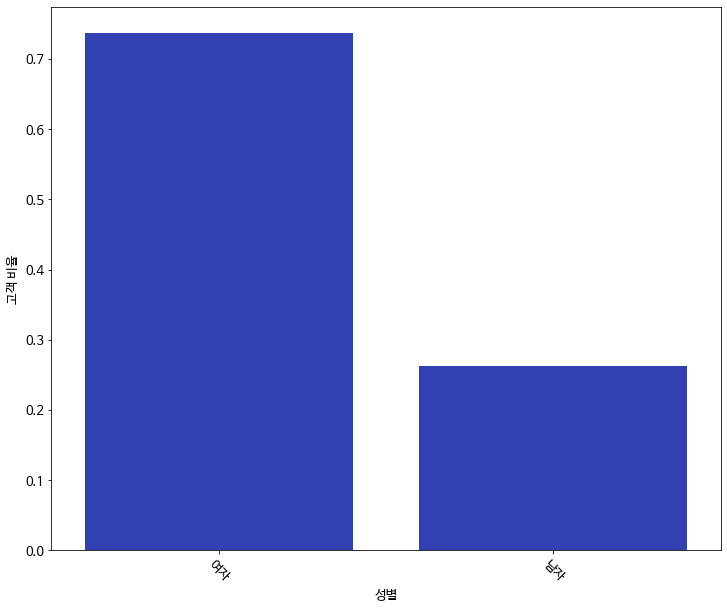

In [ ]:
mean3 = cus_df_2.groupby('성별')[['구매 횟수']].count().sort_values(by = '구매 횟수', ascending = False)
mean3['ratio'] = mean3['구매 횟수']/mean3['구매 횟수'].sum()
plt.figure(figsize = (12, 10))
sns.barplot(data = mean3, x = mean3.index, y = 'ratio', color = '#1d31c6')
plt.xticks(rotation = -45 )
# plt.title('성별 고객 비율')
# plt.text(x = 0, y = 0.4, s = '1000', fontsize = 20)
plt.xlabel('성별')
plt.ylabel('고객 비율')
plt.show()

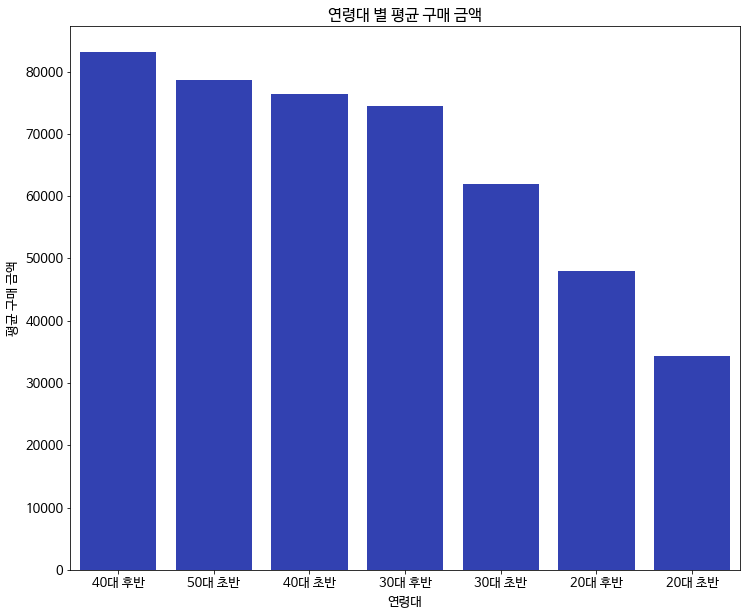

In [ ]:
mean1 = cus_df_1.groupby('연령대')['구매 금액'].mean().to_frame().sort_values(by = '구매 금액', ascending = False)
plt.figure(figsize = (12, 10))
sns.barplot(data = mean1, x = mean1.index, y = '구매 금액', color = '#1d31c6')
plt.title('연령대 별 평균 구매 금액')
plt.ylabel('평균 구매 금액')
plt.show()

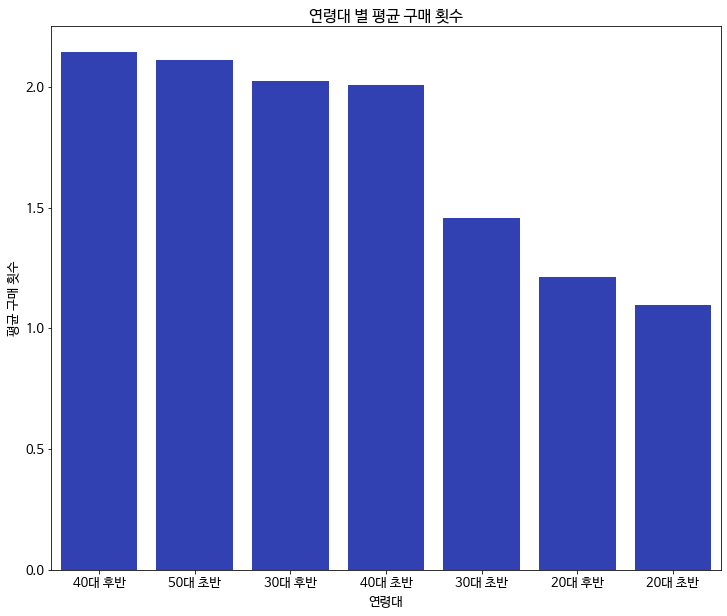

In [ ]:
mean2 = cus_df_1.groupby('연령대')['구매 횟수'].mean().to_frame().sort_values(by = '구매 횟수', ascending = False)
plt.figure(figsize = (12, 10))
sns.barplot(data = mean2, x = mean2.index, y = '구매 횟수', color = '#1d31c6')
plt.title('연령대 별 평균 구매 횟수')
plt.ylabel('평균 구매 횟수')
plt.show()

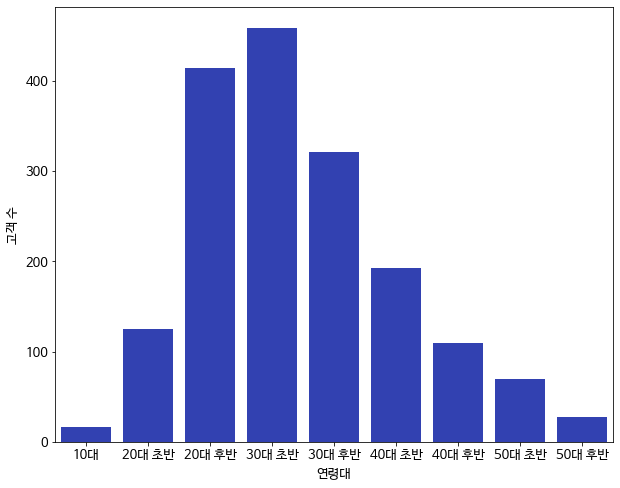

In [ ]:
mean3 = cus_df_1.groupby('연령대')[['구매 횟수']].count().sort_values(by = '연령대', ascending = True)
plt.figure(figsize = (10, 8))
sns.barplot(data = mean3, x = mean3.index, y = '구매 횟수', color = '#1d31c6')#palette="Blues_d")
# plt.title('한달어스의 연령대 별 고객 수')
plt.ylabel('고객 수')
plt.show()

In [ ]:
cus_df_2.groupby('주소 분할')[['구매 횟수']].count().sort_values(by = '구매 횟수', ascending = True)

,구매 횟수
주소 분할,
울산,1
광주,2
제주특별자치도,2
세종특별자치시,3
전북,3
충북,3
강원,6
경남,7
경북,7


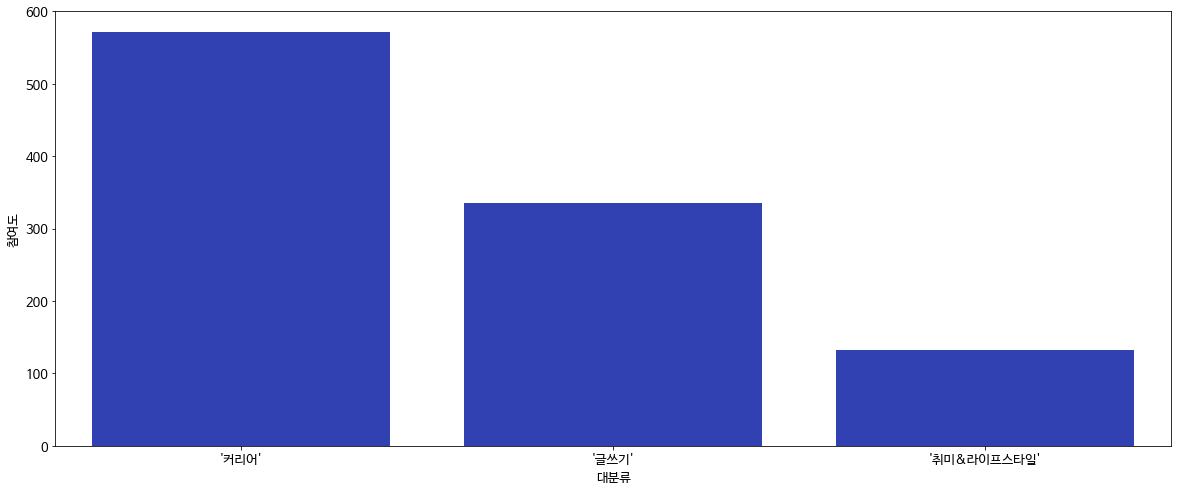

In [ ]:
data = {"'커리어'": 572, "'글쓰기'": 336, "'취미&라이프스타일'": 132}
example = pd.DataFrame()
example['대분류'] = list(data.keys())
example['개수'] = list(data.values())
#import seaborn as sns 
# example = example.groupby('중분류')[['구매 횟수']].count().sort_values(by = '구매 횟수', ascending = False)
names = list(data.keys())
values = list(data.values())

example = example.sort_values(by = '개수', ascending = False)[: 10]

plt.figure(figsize = (20, 8))
sns.barplot(data = example, x ='대분류', y ='개수', color = '#1d31c6')#palette="Blues_d")
# plt.title('한달어스의 연령대 별 고객 수')
plt.ylabel('참여도')
plt.show()

# plt.bar(range(len(data)), values, tick_label=names)
# plt.show()

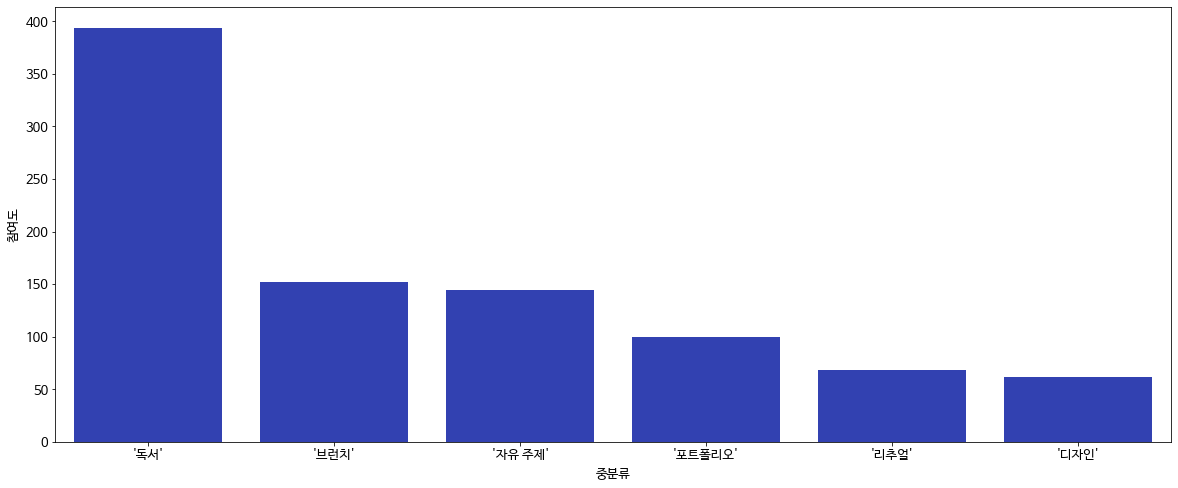

In [ ]:
data = {"'독서'": 394, "'브런치'": 152, "'블로그'": 40, "'포트폴리오'": 100, "'디자인'": 62, "'자유 주제'": 144, "'리추얼'": 68, "'운동'": 18,  "'기타'": 18, "'보물지도'": 31, "'코칭'": 2, "'개발'": 1, "'이벤트'": 2, "'영어쓰기'": 10, "'경제/시사'": 3, "'콘텐츠'": 3, "'회고'": 6, "'명상'": 4}
example = pd.DataFrame()
example['중분류'] = list(data.keys())
example['개수'] = list(data.values())
#import seaborn as sns 
# example = example.groupby('중분류')[['구매 횟수']].count().sort_values(by = '구매 횟수', ascending = False)
names = list(data.keys())
values = list(data.values())

example = example.sort_values(by = '개수', ascending = False)[: 6]

plt.figure(figsize = (20, 8))
sns.barplot(data = example, x ='중분류', y ='개수', color = '#1d31c6')#palette="Blues_d")
# plt.title('한달어스의 연령대 별 고객 수')
plt.ylabel('참여도')
plt.show()

# plt.bar(range(len(data)), values, tick_label=names)
# plt.show()

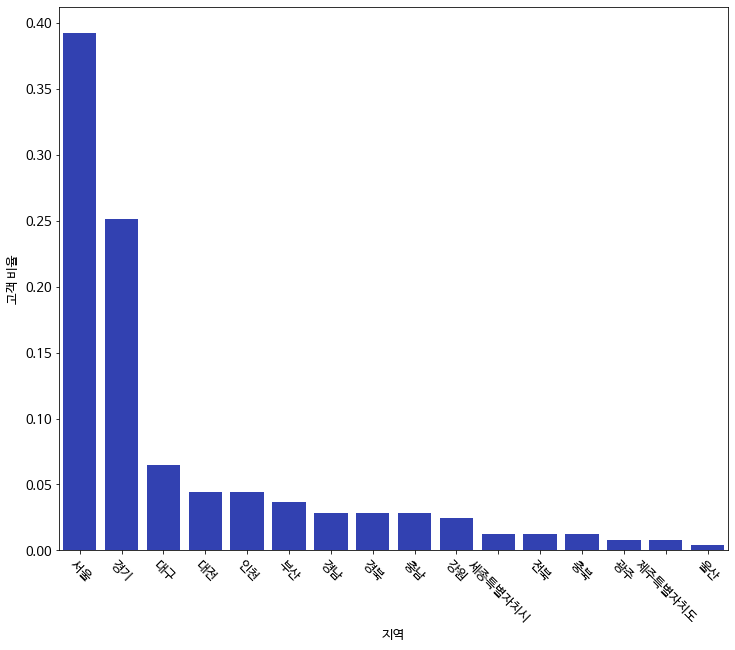

In [ ]:
cus_df_2 = cus_df_1[~cus_df_1['주소 분할'].isin(['-'])].reset_index(drop = True)
mean3 = cus_df_2.groupby('주소 분할')[['구매 횟수']].count().sort_values(by = '구매 횟수', ascending = False)
mean3['ratio'] = mean3['구매 횟수']/mean3['구매 횟수'].sum()
plt.figure(figsize = (12, 10))
sns.barplot(data = mean3, x = mean3.index, y = 'ratio', color = '#1d31c6')
plt.xticks(rotation = -45 )
# plt.title('지역 별 고객 비율')
plt.xlabel('지역')
plt.ylabel('고객 비율')
plt.show()

b'Skipping line 196: expected 16 fields, saw 18\nSkipping line 210: expected 16 fields, saw 18\n'


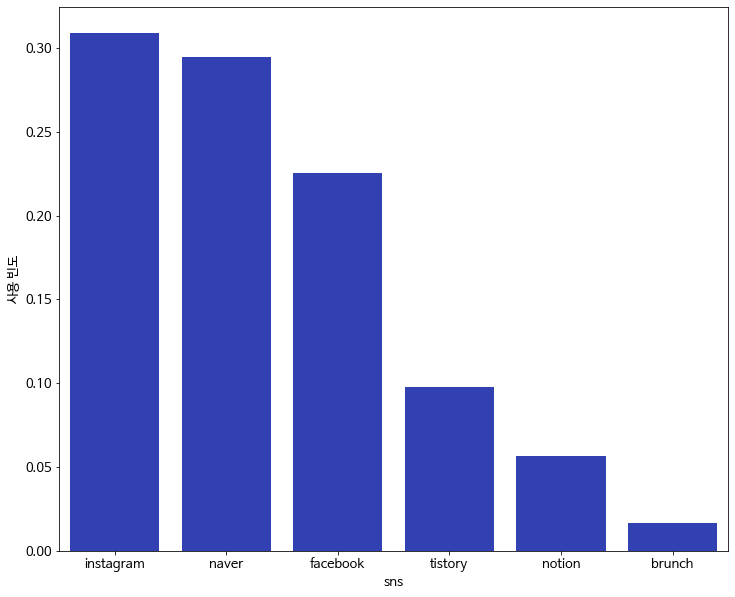

In [ ]:
a = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/handal/handal_link.csv', header = 0, error_bad_lines = False)['site_name'].value_counts()[: 6].to_frame()
a['ratio'] = a['site_name']/a['site_name'].sum()
plt.figure(figsize = (12, 10))
sns.barplot(data = a, x = a.index, y = 'ratio', color = '#1d31c6')
# plt.title('sns 별 사용 빈도')
plt.xlabel('sns')
plt.ylabel('사용 빈도')
plt.show()

In [ ]:
x = ['30days', '3days', '7days', 'event', '14days']
y = [1455, 600, 328, 148, 25]
example = pd.DataFrame()
example['기간'] = x
example = example.set_index('기간')
example['count'] = y
example

plt.figure(figsize = (10, 8))
sns.barplot(data = example, x = example.index, y = 'count', color = '#1d31c6')#palette="Blues_d")
# plt.title('한달어스의 연령대 별 고객 수')
plt.ylabel('고객 수')
plt.show()

,count
기간,
30days,1455
3days,600
7days,328
event,148
14days,25


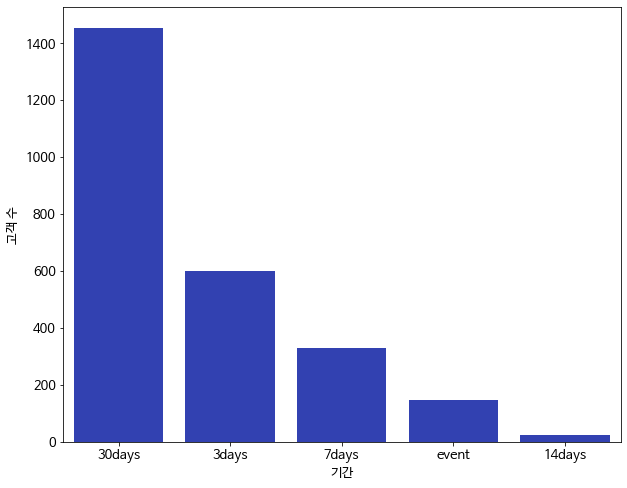

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(data = example, x = example.index, y = 'count', color = '#1d31c6')#palette="Blues_d")
# plt.title('한달어스의 연령대 별 고객 수')
plt.ylabel('고객 수')
plt.show()

In [ ]:
a = [0.7471783295711061,0.9094650205761317 ]
b = [0.7584650112866818, 0.9135802469135802]
c = ['라이트 고객', '라이트 고객 제외한 고객']
tt = pd.DataFrame()
tt['분류'] = c
tt['이메일 수신 동의 비율']  = a
tt = tt.set_index('분류')
tt['문자 수신 동의 비율'] = b
tt

,이메일 수신 동의 비율,문자 수신 동의 비율
분류,,
라이트 고객,0.747178,0.758465
라이트 고객 제외한 고객,0.909465,0.913580


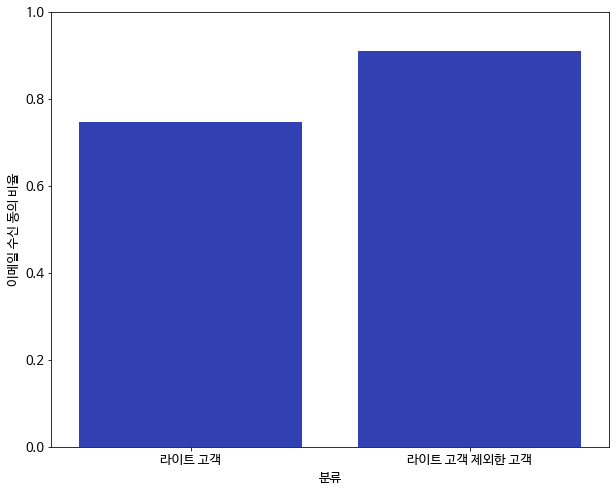

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(data = tt, x = tt.index, y = '이메일 수신 동의 비율', color = '#1d31c6')#palette="Blues_d")
# plt.title('한달어스의 연령대 별 고객 수')
plt.ylabel('이메일 수신 동의 비율')
plt.ylim(0, 1)
plt.show()

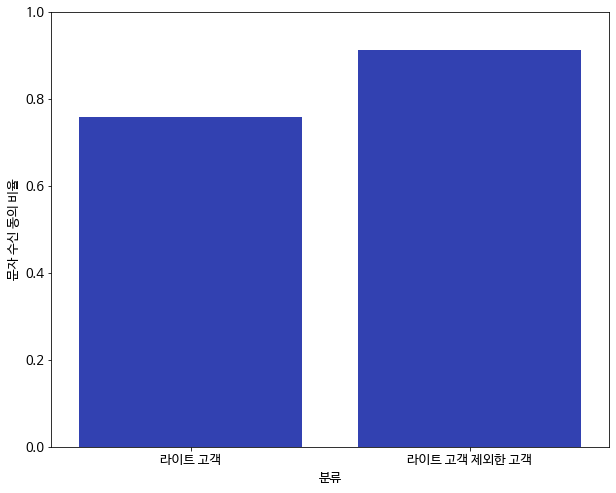

In [ ]:
plt.figure(figsize = (10, 8))
sns.barplot(data = tt, x = tt.index, y = '문자 수신 동의 비율', color = '#1d31c6')#palette="Blues_d")
# plt.title('한달어스의 연령대 별 고객 수')
plt.ylabel('문자 수신 동의 비율')
plt.ylim(0, 1)
plt.show()

In [ ]:
order[order['상품 이름'] == '한달 러닝']

,상품 이름,주문자 이름,휴대폰 번호,이메일,상품별 결제 금액,상품별 주문 상태,배송지 이름,배송지 휴대폰 번호,우편번호,배송지 주소,배송 시 요청 사항,주문 상태,주문 품목 개수,부분 취소 금액,부분 취소 후 잔액,상품 합계 금액,배송비,배송 메모,주문 일자,결제 방법,수량,메모,주문 제목,결제 금액,취소/반품 상품 수량,주문번호,상품 주문번호 (네이버페이),주문자 유형,주문자 아이디,택배회사,송장번호,개인통관고유부호,사용한 적립금,적립될 적립금,사용한 쿠폰,쿠폰 할인 금액,사용한 할인 코드,할인 코드 할인 금액,총 할인 금액,상품 부분 취소 전 상품 합계 금액,상품 부분 취소 전 배송비,상품 부분 취소 전 사용한 적립금,상품 부분 취소 전 적립될 적립금,상품 부분 취소 전 쿠폰 할인 금액,상품 부분 취소 전 할인 코드 할인 금액,상품 부분 취소 전 총 할인 금액,입금받을 계좌 정보,입금자,입금 기한,에스크로,TID,환불 계좌,취소/반품 사유,상품 코드,상품 옵션 정보,추가 옵션 정보,작성형 옵션 정보,주문 수량과 관계없이 고정된 추가 옵션 추가 금액
56,한달 러닝,정하나,010-4394-9119,in_micah@naver.com,59400,전체 취소,정하나,010-4394-9119,-,NaN,-,취소 완료,1,-,-,59400,0,NaN,2021-09-21 16:15:42,카카오페이,1,-,한달 러닝,59400,1,20210921MC6IN,-,회원,-,기타,-,NaN,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,T2944441218287909514,-,다른 프로그램 신청,r0001,-,-,-,-
97,한달 러닝,정명은,010-6717-1178,rothy33@naver.com,66000,승인,정명은,010-6717-1178,-,NaN,-,결제 완료,1,-,-,66000,0,-,2021-08-30 12:20:39,-,1,-,한달 러닝,0,0,20210830WDXRA,-,회원,-,기타,-,NaN,0,0,VIP PASS 쿠폰,66000,-,0,66000,-,-,-,-,-,-,-,-,-,-,-,-,-,-,r0001,-,-,-,-
161,한달 러닝,신유림,010-6652-9667,syyh10@naver.com,62700,승인,신유림,010-6652-9667,-,NaN,-,결제 완료,1,-,-,62700,0,-,2021-08-16 15:48:44,카카오페이,1,-,한달 러닝,57700,0,20210816JV2HX,-,회원,-,기타,-,NaN,0,0,[ 국내 스타트업 경진대회 1위 기념 쿠폰 ],5000,-,0,5000,-,-,-,-,-,-,-,-,-,-,-,T2931075207050411848,-,-,r0001,-,-,-,-
194,한달 러닝,송효주,010-6436-2349,flography2@naver.com,59400,승인,송효주,010-6436-2349,-,NaN,-,결제 완료,1,-,-,59400,0,-,2021-08-12 14:39:18,신용 / 체크카드,1,-,한달 러닝,59400,0,20210812HLKLM,-,회원,-,기타,-,NaN,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,StdpayCARDSIXhandal120210812143945800147,-,-,r0001,-,-,-,-
214,한달 러닝,박설희,010-5775-3953,pshelley57@naver.com,59400,승인,박설희,010-5775-3953,-,NaN,-,결제 완료,1,-,-,59400,0,-,2021-08-11 18:42:41,카카오페이,1,-,한달 러닝,59400,0,20210811YB14O,-,회원,-,기타,-,NaN,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,T2929264607749388721,-,-,r0001,-,-,-,-
224,한달 러닝,조아라,010-9966-2558,ijoara000@naver.com,59400,승인,조아라,010-9966-2558,-,NaN,-,결제 완료,1,-,-,59400,0,-,2021-08-11 17:11:22,신용 / 체크카드,1,-,한달 러닝,59400,0,20210811JS9CG,-,회원,-,기타,-,NaN,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,INIMX_CARDSIXhandal120210811171259225040,-,-,r0001,-,-,-,-
233,한달 러닝,방숙현,010-4426-2470,thine1116@hotmail.com,59400,승인,방숙현,010-4426-2470,-,NaN,-,결제 완료,1,-,-,59400,0,-,2021-08-11 09:10:58,카카오페이,1,-,한달 러닝,59400,0,20210811V5C3H,-,회원,-,기타,-,NaN,0,0,-,0,-,0,0,-,-,-,-,-,-,-,-,-,-,-,T2929117273192059870,-,-,r0001,-,-,-,-
262,한달 러닝,지희수,010-3288-7968,heesoo33@hanmail.net,59400,승인,지희수,010-3288-7968,-,NaN,-,결제 완료,1,-,-,59400,0,-,2021-08-08 23:06:18,신용 / 체크카드,1,-,한달 러닝,54400,0,20210808KXTHN,-,회원,-,기타,-,NaN,0,0,[ 국내 스타트업 경진대회 1위 기념 쿠폰 ],5000,-,0,5000,-,-,-,-,-,-,-,-,-,-,-,INIMX_CARDSIXhandal120210808230650915500,-,-,r0001,-,-,-,-
273,한달 러닝,정선욱,010-9086-9320,seonuk1202@naver.com,59400,승인,정선욱,010-9086-9320,-,NaN,-,결제 완료,1,-,-,59400,0,-,2021-08-08 20:29:26,신용 / 체크카드,1,-,한달 러닝,54400,0,20210808P6GOS,-,회원,-,기타,-,NaN,0,0,[ 국내 스타트업 경진대회 1위 기념 쿠폰 ],5000,-,0,5000,-,-,-,-,-,-,-,-,-,-,-,StdpayCARDSIXhandal120210808203013523664,-,-,r0001,-,-,-,-
282,한달 러닝,전성규,010-9204-5346,sungkyu21@naver.com,59400,승인,전성규,010-9204-5346,-,NaN,-,결제 완료,1,-,-,59400,0,-,2021-08-08 11:25:51,카카오페이,1,-,한달 러닝,54400,0,20210808K9EGH,-,회원,-,기타,-,NaN,0,0,[ 국내 스타트업 경진대회 1위 기념 쿠폰 ],5000,-,0,5000,-,-,-,-,-,-,-,-,-,-,-,T2928038776838734556,-,-,r0001,-,-,-,-


In [ ]:
cus_df['첫 상품대분류'].value_counts()

커리어          610
-            515
글쓰기          415
취미&라이프스타일    122
굿즈            58
기타            26
코칭             1
Name: 첫 상품대분류, dtype: int64

In [ ]:
cus_df_3 = cus_df[cus_df['첫 상품대분류'] == '커리어'].reset_index(drop = True)
cus_df_3 = cus_df_3[cus_df_3['연령대'].isin(['20대 초반', '20대 후반', '30대 초반', '30대 후반', '40대 초반', '40대 후반', '50대 초반', '10대', '60대 이상'])].reset_index(drop = True)

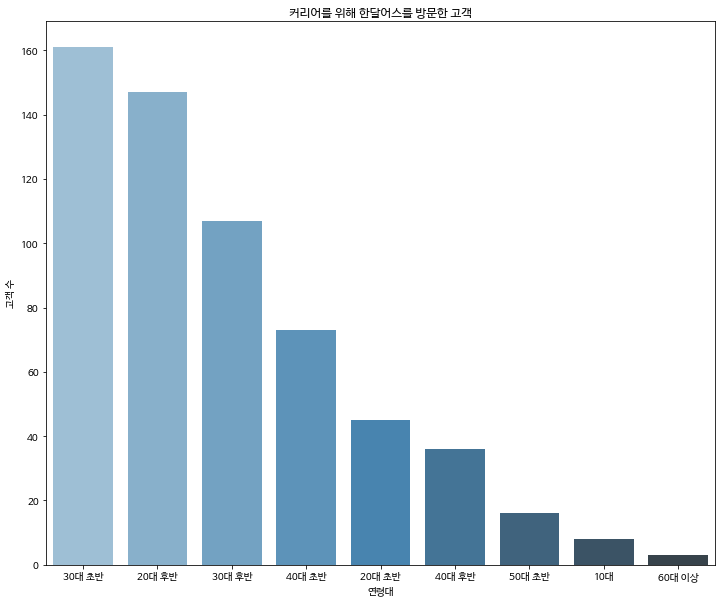

In [ ]:
cus_df_3['연령대'].value_counts().to_frame()
plt.figure(figsize = (12, 10))
sns.barplot(data = cus_df_3['연령대'].value_counts().to_frame(), x = cus_df_3['연령대'].value_counts().to_frame().index, y = '연령대', palette="Blues_d")
plt.title('커리어를 위해 한달어스를 방문한 고객')
plt.xlabel('연령대')
plt.ylabel('고객 수')
plt.show()

# 1~2번만 구매하는 고객(찍먹?)을 더 많이 유입시키는 것이 유리한지, vip 고객들을 늘리는것이 유리한지

In [ ]:
cus_df['구매 금액'].sum()-50652710

58267620

In [ ]:
# vip는 상위 몇 퍼센트로 정해야 할까 ?
# 일단 10퍼센트 정도로 해보자
np.percentile(cus_df['구매 횟수'], 90)

4.0

In [ ]:
np.percentile(cus_df['구매 횟수'], 95)

6.0

In [ ]:
print('1번 구매한 고객의 수 :', len(cus_df[cus_df['구매 횟수'].isin([1])]))
print('1번 구매한 고객이 결제한 총 금액 :', cus_df[cus_df['구매 횟수'].isin([1])]['구매 금액'].sum())
print('1번 구매한 고객이 결제한 평균 금액 :', cus_df[cus_df['구매 횟수'].isin([1])]['구매 금액'].mean())

1번 구매한 고객의 수 : 734
1번 구매한 고객이 결제한 총 금액 : 28620070
1번 구매한 고객이 결제한 평균 금액 : 38991.92098092643


In [ ]:
print('1 ~ 2번 구매한 고객의 수 :', len(cus_df[cus_df['구매 횟수'].isin([1, 2])]))
print('1 ~ 2번 구매한 고객이 결제한 총 금액 :', cus_df[cus_df['구매 횟수'].isin([1, 2])]['구매 금액'].sum())
print('1 ~ 2번 구매한 고객이 결제한 평균 금액 :', cus_df[cus_df['구매 횟수'].isin([1, 2])]['구매 금액'].mean())

1 ~ 2번 구매한 고객의 수 : 949
1 ~ 2번 구매한 고객이 결제한 총 금액 : 47207420
1 ~ 2번 구매한 고객이 결제한 평균 금액 : 49744.38356164384


In [ ]:
# 4번 이상 구매하면 상위 10퍼센트의 위치한다.
print('4번 이상 구매한 고객의 수 :', len(cus_df[cus_df['구매 횟수'] >= 4]))
print('4번 이상 구매한 고객이 결제한 총 금액 :', cus_df[cus_df['구매 횟수'] >= 4]['구매 금액'].sum())
print('4번 이상 구매한 고객이 결제한 평균 금액 :', cus_df[cus_df['구매 횟수'] >= 4]['구매 금액'].mean())

4번 이상 구매한 고객의 수 : 180
4번 이상 구매한 고객이 결제한 총 금액 : 50652710
4번 이상 구매한 고객이 결제한 평균 금액 : 281403.94444444444


# csv 파일로 내보내기

In [ ]:
# cus_df.to_excel('/content/drive/MyDrive/Colab Notebooks/handal/test_2.xlsx', encoding = 'utf-16')